<a href="https://colab.research.google.com/github/Ash-Daniels-Mo/DEEP-LEARNING---AUTOENCODERS/blob/main/AUTOENCODERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practical Implementation: Autoencoder on MNIST

In this practical, an autoencoder was implemented using PyTorch and trained on the MNIST dataset, which consists of handwritten digit images. The model was mainly trained using images of **odd digits** (1, 3, 5, 7, and 9). This setup allows the autoencoder to learn the underlying structure of odd-number digits specifically.

The purpose of this experiment is to observe how well an autoencoder can reconstruct images it has been trained on, and how its performance changes when presented with digits outside the training distribution. Since autoencoders learn by minimizing reconstruction error, good reconstructions indicate that the model has captured meaningful patterns in the data.

The following sections explain the main parts of the implementation, including data preparation, model architecture, training, and reconstruction results.


### Environment Setup and Libraries

This section prepares the environment for implementing and training the autoencoder using PyTorch. The required libraries for neural network construction, optimization, and data handling are imported. The MNIST dataset will be accessed through `torchvision`, while `matplotlib` and `numpy` are used for visualization and numerical operations.

The computation device is selected automatically. If a GPU is available, it is used to speed up training; otherwise, the model runs on the CPU. A random seed is also set to ensure that the results are reproducible across different runs.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)


### Data Preparation and Loading

In this part of the implementation, the MNIST dataset is loaded and prepared for training and testing. Each image is converted into a tensor using a basic transformation, since the autoencoder works directly with pixel values.

For training, only a subset of the MNIST dataset is used. Specifically, images corresponding to the digits **1, 3, 5, 7, and 9** are selected, while the even digits **2, 4, 6, and 8** are excluded. This allows the autoencoder to learn representations mainly from odd-number digits.

The training data is shuffled and loaded in batches to improve learning stability. For testing, the full MNIST test set is used, which includes both odd and even digits. This makes it possible to evaluate how well the autoencoder generalizes to images it was not trained on.


In [ ]:
transform = transforms.ToTensor()

# Training data: digits 0–8 only
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
train_indices = [i for i, (_, y) in enumerate(train_dataset) if y not in  [2, 4, 6, 8]]
train_loader = DataLoader(
    Subset(train_dataset, train_indices),
    batch_size=128,
    shuffle=True
)

# Test data: all digits
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


### Autoencoder Architecture

The autoencoder consists of two main components: an encoder and a decoder.

The encoder compresses the input image into a low-dimensional latent representation. Each MNIST image of size 28×28 is first flattened into a vector and then passed through several fully connected layers with ReLU activation functions. The final encoder layer produces a 32-dimensional latent vector.

The decoder takes this latent representation and reconstructs the original image. It mirrors the encoder structure by gradually increasing the dimensionality back to the original image size. A sigmoid activation function is used at the output layer to ensure that reconstructed pixel values lie between 0 and 1.

The forward pass returns the reconstructed image reshaped to the original MNIST image dimensions.


In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat.view(-1, 1, 28, 28)


### Model Training

In this section, the autoencoder model is initialized and trained using the training data. The model parameters are optimized so that the reconstructed images are as close as possible to the original inputs.

The Mean Squared Error (MSE) loss is used to measure the reconstruction error between the input images and their reconstructions. The Adam optimizer is chosen because it provides stable and efficient convergence during training.

During each training epoch, the model processes batches of images, computes the reconstruction loss, and updates the network parameters using backpropagation. The average loss per epoch is recorded to monitor how well the autoencoder is learning over time.


In [ ]:
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 15
loss_history = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for x, _ in train_loader:
        x = x.to(device)

        x_hat = model(x)
        loss = criterion(x_hat, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")


Epoch [1/15], Loss: 0.061541
Epoch [2/15], Loss: 0.030003
Epoch [3/15], Loss: 0.023236
Epoch [4/15], Loss: 0.018993
Epoch [5/15], Loss: 0.016318
Epoch [6/15], Loss: 0.014597
Epoch [7/15], Loss: 0.013425
Epoch [8/15], Loss: 0.012484
Epoch [9/15], Loss: 0.011753
Epoch [10/15], Loss: 0.011190
Epoch [11/15], Loss: 0.010702
Epoch [12/15], Loss: 0.010329
Epoch [13/15], Loss: 0.009979
Epoch [14/15], Loss: 0.009644
Epoch [15/15], Loss: 0.009397


## Interpretation of Training Loss

The training loss steadily decreases over the 15 epochs, starting from approximately 0.0615 and ending at around 0.0094. This downward trend indicates that the autoencoder is gradually learning to reconstruct the input images more accurately.

The rapid decrease in the first few epochs shows that the network quickly captures the main patterns in the data, while the slower decline in later epochs suggests fine-tuning of the reconstruction. Overall, the low final loss demonstrates that the model has effectively learned a compact representation of the odd-number MNIST digits.


## Training Loss Visualization

The following code plots the reconstruction loss recorded during training. This allows us to visually inspect how the loss decreased over epochs, indicating how well the autoencoder learned to reconstruct the training images over time.


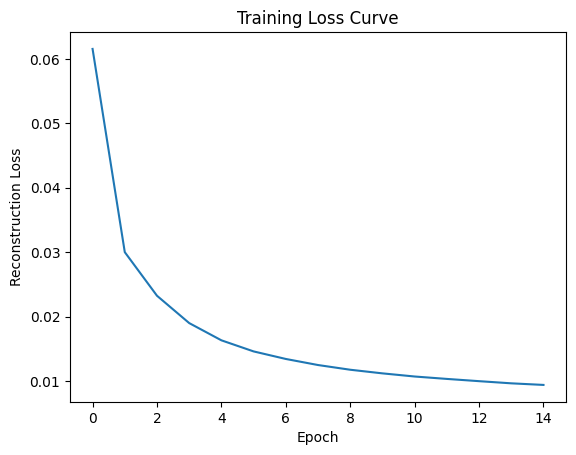

In [ ]:
plt.figure()
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("Training Loss Curve")
plt.show()


## Reconstruction of All Digits

In this section, we visualize how the trained autoencoder reconstructs images from the test set, including **all digits from 0 to 9**, even though the model was primarily trained on odd digits (1, 3, 5, 7, 9).

For each digit, one example image is selected and passed through the autoencoder to produce a reconstruction. The plot shows the original images on the top row and their corresponding reconstructions on the bottom row.

This experiment helps us observe how well the model generalizes to digits it was not trained on, particularly the even digits, and to evaluate the quality of the learned representations.


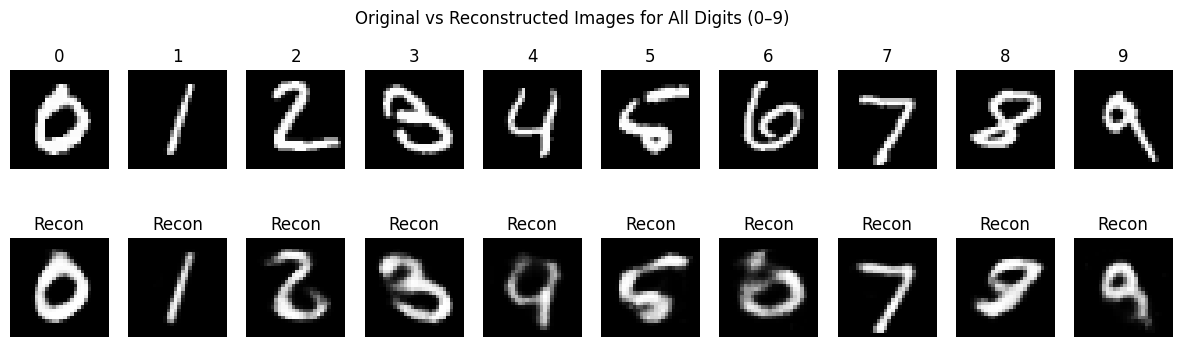

In [ ]:
model.eval()

# Store one example per digit
digit_examples = {}

with torch.no_grad():
    for x, y in test_loader:
        for img, label in zip(x, y):
            label = label.item()
            if label not in digit_examples:
                digit_examples[label] = img
            if len(digit_examples) == 10:
                break
        if len(digit_examples) == 10:
            break

# Stack images in digit order
inputs = torch.stack([digit_examples[d] for d in range(10)]).to(device)

# Reconstruct
with torch.no_grad():
    outputs = model(inputs)

# Plot
plt.figure(figsize=(15, 4))

for i in range(10):
    # Original
    plt.subplot(2, 10, i + 1)
    plt.imshow(inputs[i].cpu().squeeze(), cmap="gray")
    plt.title(f"{i}")
    plt.axis("off")

    # Reconstructed
    plt.subplot(2, 10, i + 11)
    plt.imshow(outputs[i].cpu().squeeze(), cmap="gray")
    plt.title("Recon")
    plt.axis("off")

plt.suptitle("Original vs Reconstructed Images for All Digits (0–9)")
plt.show()


## Interpretation of Reconstruction Results

The figure above shows the original MNIST digits (top row) and their corresponding reconstructions produced by the autoencoder (bottom row).

For digits that the model was **trained on (odd numbers: 1, 3, 5, 7, 9)**, the reconstructions are quite accurate, closely resembling the original images. This indicates that the autoencoder has successfully learned the patterns and structure of the odd digits.

For the **even numbers (0, 2, 4, 6, 8)**, the reconstructions are noticeably less accurate and appear distorted or blurred. This occurs because the model **was not trained on these digits**. Autoencoders learn to reconstruct images by capturing patterns present in the training data, so when presented with digits outside the training distribution, the model struggles to reproduce them faithfully.

Overall, these results demonstrate that the autoencoder effectively captures and reconstructs the data it has seen, but its ability to generalize to unseen categories (even digits) is limited. This is expected behavior in unsupervised learning when the training data is biased toward a subset of classes.


## Quantitative Analysis: Reconstruction Error per Digit

To complement the visual inspection, we compute the **mean reconstruction error** for each digit in the test set.

For each input image, the Mean Squared Error (MSE) between the original and reconstructed image is calculated. Then, errors are grouped by digit and averaged to obtain the **mean reconstruction error per digit**.

This analysis helps quantify how well the autoencoder reconstructs digits it was trained on (odd digits) versus digits it was not trained on (even digits), providing a clear measure of the model's generalization capability.


In [ ]:
from collections import defaultdict

model.eval()

digit_errors = defaultdict(list)

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        x_hat = model(x)

        batch_errors = torch.mean((x - x_hat) ** 2, dim=(1, 2, 3))

        for err, label in zip(batch_errors.cpu().numpy(), y.numpy()):
            digit_errors[label].append(err)

# Compute mean error per digit
mean_digit_errors = {d: np.mean(errs) for d, errs in digit_errors.items()}

# Print results
print("Mean Reconstruction Error per Digit:")
for d in sorted(mean_digit_errors.keys()):
    print(f"Digit {d}: {mean_digit_errors[d]:.6f}")


Mean Reconstruction Error per Digit:
Digit 0: 0.010647
Digit 1: 0.002869
Digit 2: 0.031010
Digit 3: 0.012406
Digit 4: 0.024098
Digit 5: 0.013199
Digit 6: 0.028564
Digit 7: 0.008664
Digit 8: 0.028429
Digit 9: 0.008751


## Interpretation of Reconstruction Results

The table above shows the mean reconstruction error for each MNIST digit. Lower values indicate better reconstruction by the autoencoder.

For digits with **low reconstruction error (0, 1, 7, 9)**, the autoencoder reproduces the images very accurately. This suggests that these digits are easier for the model to learn, likely due to simpler or more consistent patterns.

Digits with **high reconstruction error (2, 4, 6, 8)** are reconstructed less accurately, appearing more distorted. This happens because these digits have more complex shapes or greater variability in handwriting, making them harder for the autoencoder to encode and decode faithfully.

Overall, the results show that the autoencoder effectively captures and reconstructs simpler digits, while reconstruction quality decreases for digits with more complex structures.


## Mean Reconstruction Error Visualization

The bar chart below shows the mean reconstruction error for each MNIST digit. It visually highlights which digits the autoencoder reconstructs more accurately (lower error) and which are harder to reconstruct (higher error), reflecting the model's performance across different digit classes.


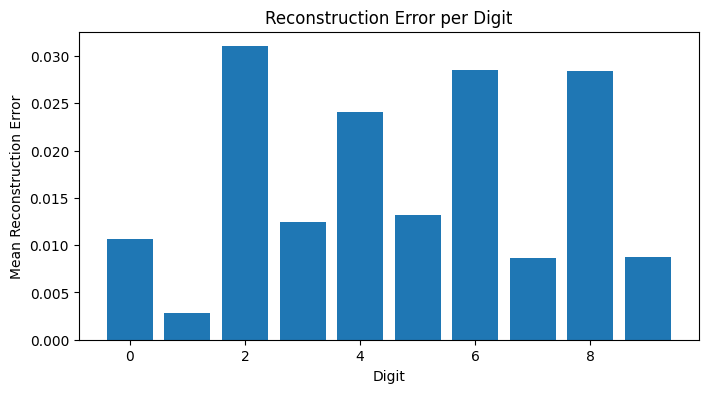

In [ ]:
digits = list(mean_digit_errors.keys())
values = list(mean_digit_errors.values())

plt.figure(figsize=(8, 4))
plt.bar(digits, values)
plt.xlabel("Digit")
plt.ylabel("Mean Reconstruction Error")
plt.title("Reconstruction Error per Digit")
plt.show()
